In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.cm import get_cmap
import numpy as np

In [2]:
directions = np.array([[1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]])

In [3]:
class Agent():
    def __init__(self, x, y, index=None, perception_radius=4, c=1):
        self.x = x
        self.y = y
        self.c = c
        self.perception_radius = perception_radius
        self.index = index
        self.locked = False
        
    def move(self, arena):  # move in a random direction
        x, y = self.x, self.y
        norm = 0
        x_avg = 0
        y_avg = 0
        arena_x = arena.shape[0]
        arena_y = arena.shape[1]
        
        # calculating "center of mass" of agents in NxN area
        for i in range(-self.perception_radius, self.perception_radius+1):
            for j in range(-self.perception_radius, self.perception_radius+1):
                x_ = (x + i) % arena_x
                y_ = (y + j) % arena_y
                count = arena[y_][x_]
                norm += count
                x_avg += i*count
                y_avg += j*count
                
        x_avg /= norm
        y_avg /= norm
        
        theta = 2*np.pi*np.random.random() #random direction
        
        v_x = np.cos(theta) + self.c*x_avg  # attractive force towards center of mass
        v_y = np.sin(theta) + self.c*y_avg
        
        s = v_y/v_x
        if v_x >= 0:  # calculating the perturbed angle
            theta = np.arctan(s)
        else:
            theta = np.arctan(s) + np.pi
            
        ind = int(8*theta/(2*np.pi)) % 8
        v = directions[ind].copy()
        
        self.x = (x + v[0]) % arena_x
        self.y = (y + v[1]) % arena_y

In [8]:
class Simulation():
    def __init__(self, population_size, arena_dims=(20, 20), p_unlocking=0.01, n_density=0.4, perception_radius=4, c=1):
        self.arena_x = arena_dims[0]
        self.arena_y = arena_dims[1]
        
        self.population = [ 
            Agent(
                np.random.randint(self.arena_x), np.random.randint(self.arena_y), 
                index=i, perception_radius=perception_radius, c=c
            ) 
            for i in range(population_size) 
        ]
        
        self.arena_active = np.array([[0 for _ in range(self.arena_x)] for _ in range(self.arena_y)])
        self.arena_locked = self.arena_active.copy()
        self.arena = None
        self.history = None
        
        self.p_unlocking = p_unlocking
        self.n_threshold = 1.0/(n_density*(2*perception_radius + 1)**2)
        
        self.setup()
        
    def setup(self):  # place agents into arena
        for agent in self.population:  
            x = agent.x
            y = agent.y

            # code below assumes no agent is locked
            if self.arena_active[y][x] >= 1: # may be strange but the agent is placed underneath others
                agent.locked = True
                self.arena_locked[y][x] += 1
            else:
                self.arena_active[y][x] += 1
                
        self.arena = self.arena_active + self.arena_locked
        self.history = np.expand_dims(self.arena.copy(), axis=2)
        
                
    def move_agents(self):  # movement logic
        for agent in self.population: 
            if not agent.locked:  # locked agents won't move
                x_0, y_0 = agent.x, agent.y
                x, y = agent.x, agent.y 
                
                br = 0
                while self.arena_active[y][x] >= 1: #check for collisions, make agent retry
                    if self.arena_locked[y][x] - self.arena_locked[y_0][x_0] <= 1:
                        agent.x, agent.y = x_0, y_0
                        agent.move(self.arena)
                        x, y = agent.x, agent.y
                    
                    br +=1
                    if br >= 10: # shouldn't trigger but just in case
                        agent.x, agent.y = x_0, y_0
                        x, y = x_0, y_0
                        break
                
                self.arena_active[y_0][x_0] -= 1
                self.arena_active[y][x] += 1
                
                    
    def update_states(self): # locking/unlocking logic
        for agent in self.population: 
            x, y = agent.x, agent.y

            if not agent.locked:
                locked_neighbors = 0

                for i in range(3): # count how many locked neighbors there are
                    for j in range(3):
                        y_ = (y + i - 1) % self.arena_y
                        x_ = (x + j - 1) % self.arena_x
                        if self.arena_locked[y_][x_] >= 1:
                            locked_neighbors += 1

                alpha = locked_neighbors*self.n_threshold
                r = np.random.random()

                if r < alpha or r < 0.0001:  # agent more likely to become locked with more locked neighbors + flat base chance of locking
                    agent.locked = True
                    self.arena_active[y][x] -= 1
                    self.arena_locked[y][x] += 1
                    continue

            elif agent.locked and self.arena_active[y][x] == 0: # uncovered locked agents can randomly unlock
                r = np.random.random()
                if r < self.p_unlocking:
                    agent.locked = False
                    self.arena_locked[y][x] -= 1
                    self.arena_active[y][x] += 1
                    
    def show_arena(self, cmap="Purples"):
        plt.imshow(self.arena, cmap=cmap)
        
    def step(self, n):
        for _ in range(n):
            sim.move_agents()
            sim.update_states()
            
            self.arena = self.arena = self.arena_active + self.arena_locked
            self.history = np.append(self.history, np.expand_dims(self.arena, axis=2), axis=2)
            
        #self.show_arena()
        
    def animate_frame(self, i):
        frame = plt.imshow(
            self.history[:, :, i], vmax=self.max, extent=(0, self.arena_x, 0, self.arena_y), cmap="Purples")
        return frame
        
    def animate_history(self, path, title=""):
        self.max = np.max(self.history)
        
        Writer = animation.writers["ffmpeg"]
        writer = Writer(fps=14, bitrate=1200)
        
        fig = plt.figure(figsize=(10,6))
        plt.title(title)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.xticks([0, self.arena_x])
        plt.yticks([0, self.arena_y])
        
        
        ani = animation.FuncAnimation(fig, self.animate_frame, frames=self.history.shape[2])
        ani.save(path, writer=writer)

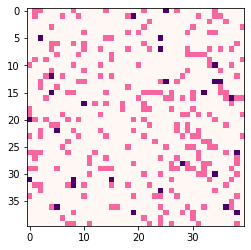

In [17]:
sim = Simulation(300, arena_dims=(40,40), n_density=0.3, p_unlocking=0.1, c=0)

sim.show_arena(cmap="RdPu")

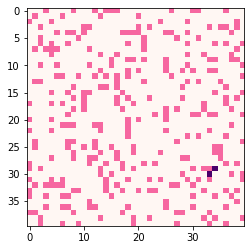

In [18]:
sim.step(100)
sim.show_arena(cmap="RdPu")

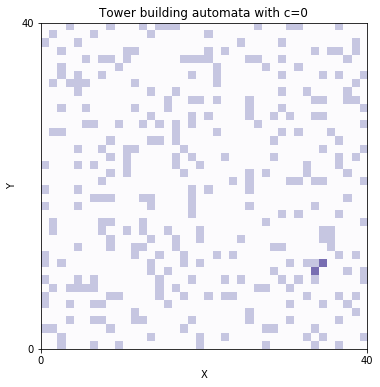

In [19]:
sim.animate_history("videos/Automata_1.mp4", title="Tower building automata with c=0")